# Auto-tuning Kalman Filter on a recorded 2D Fly Trajectory

In [1]:
import numpy as np
np.random.seed(10015)
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

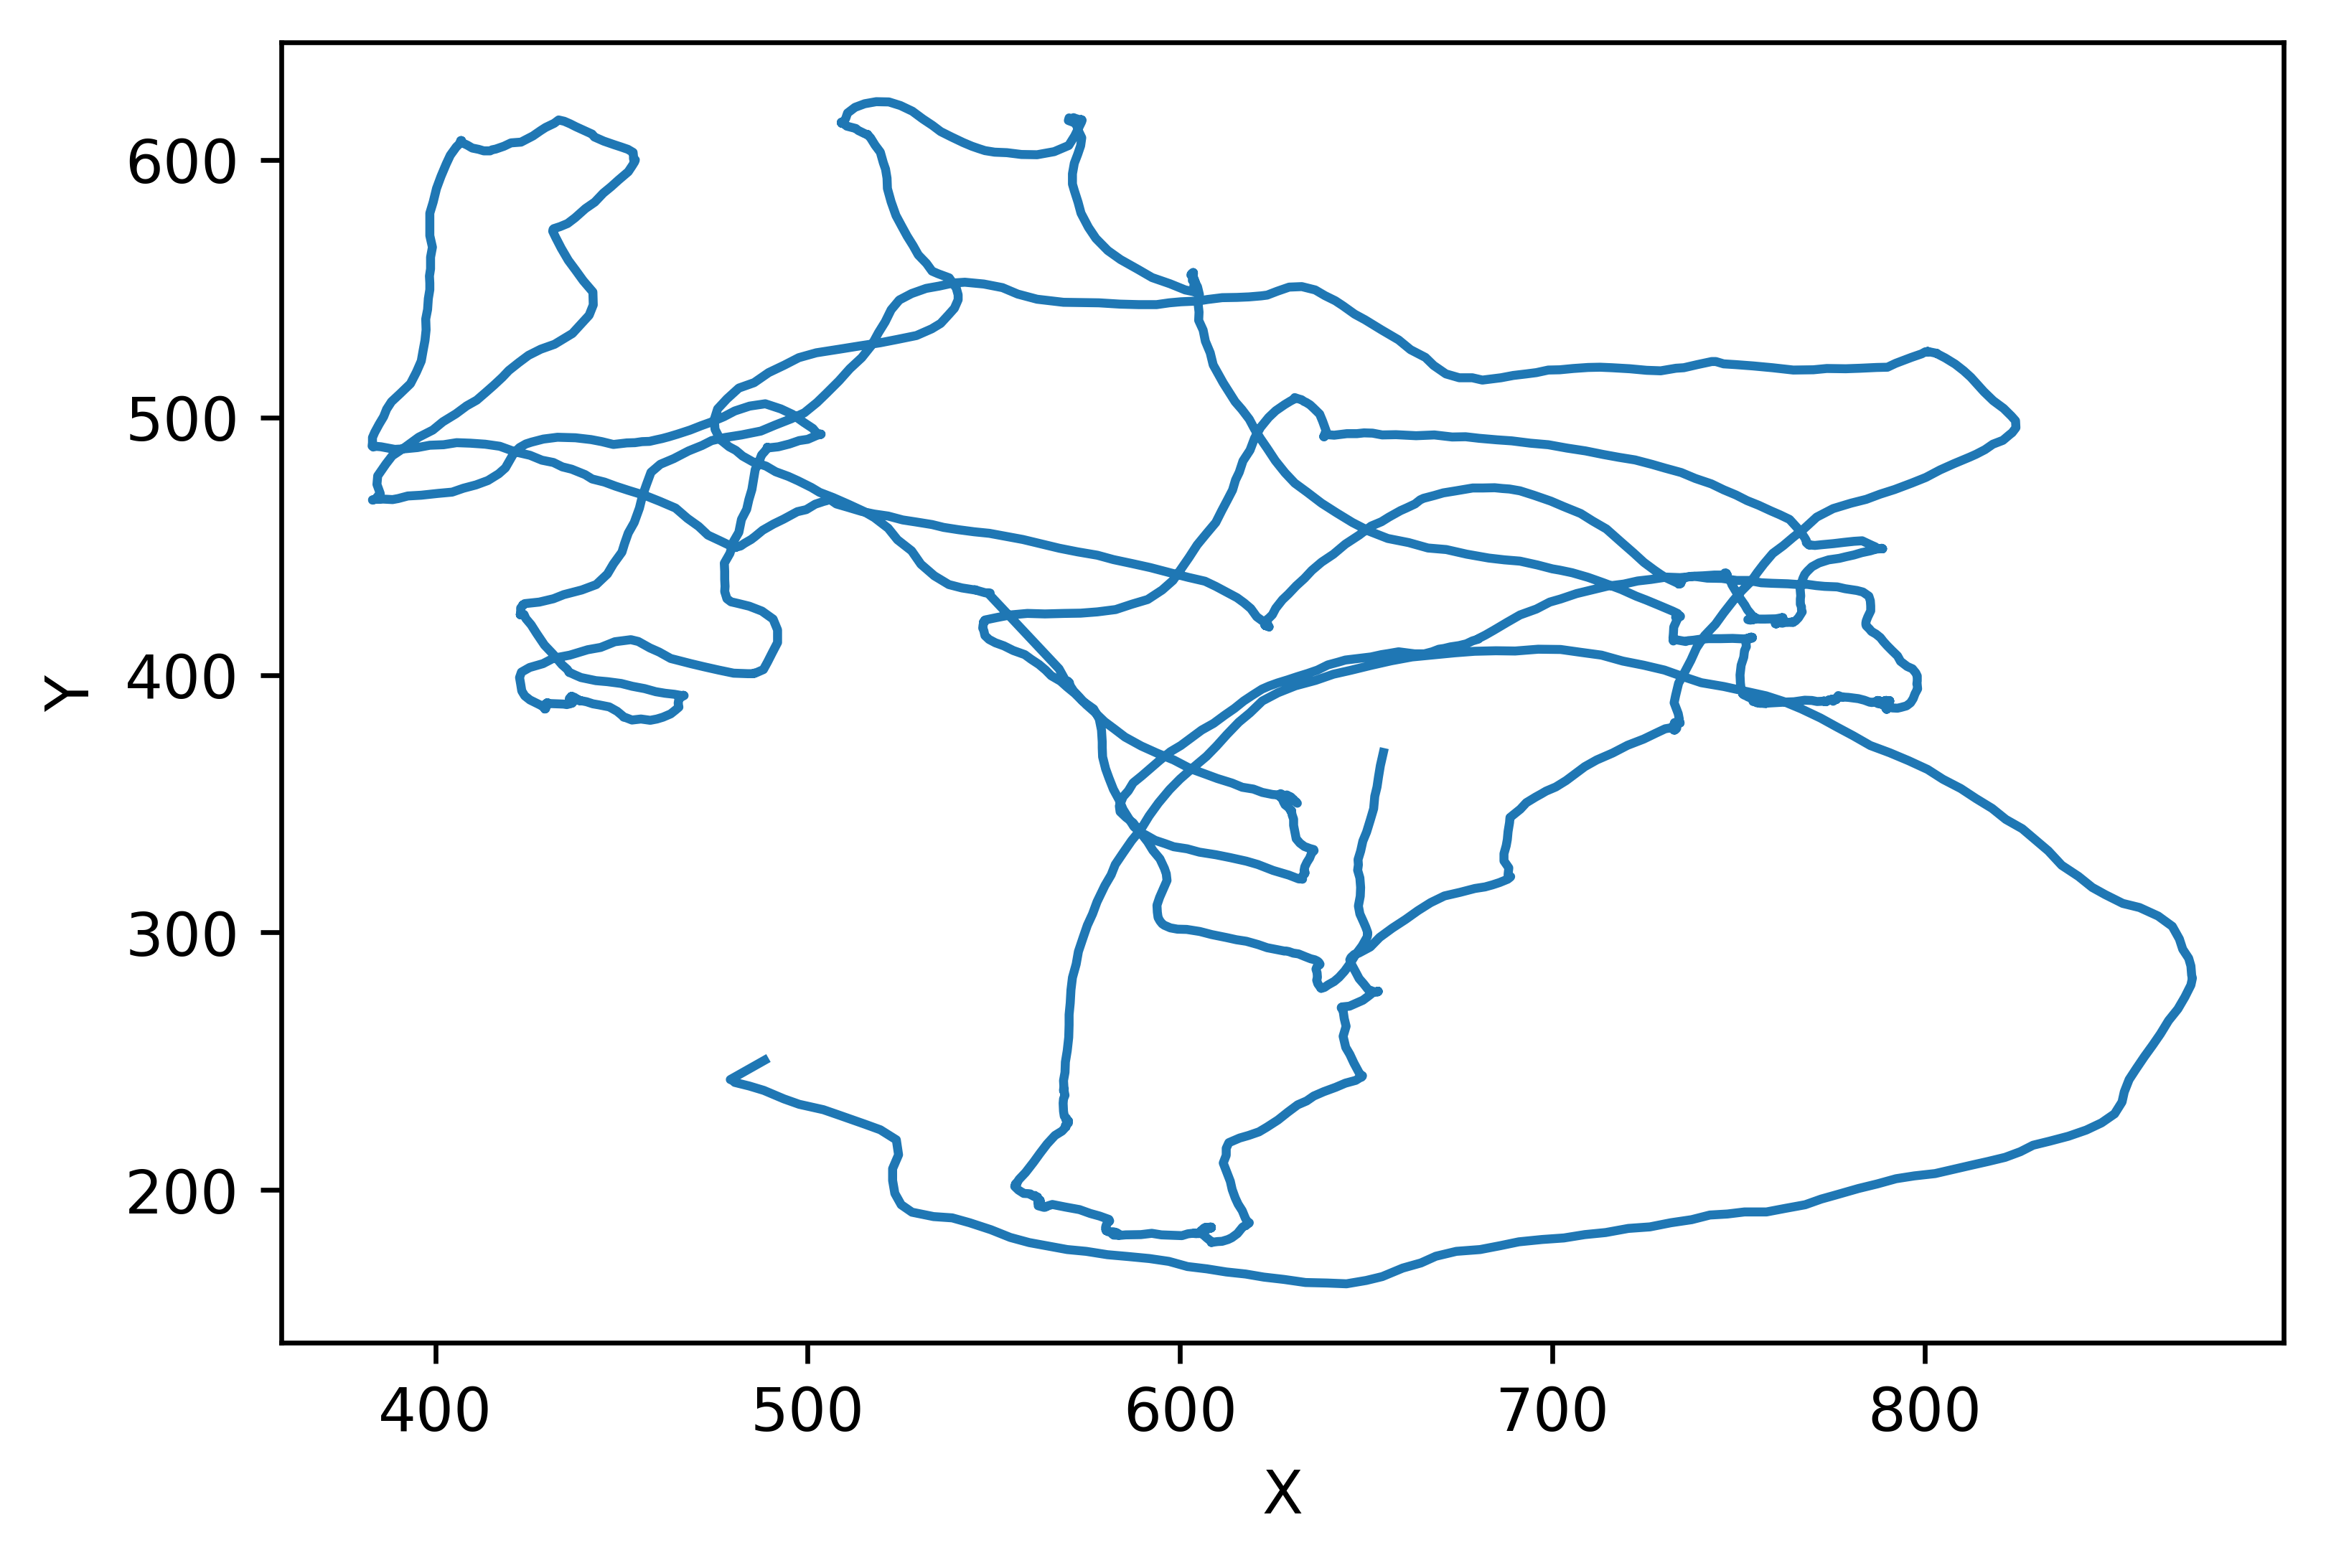

In [2]:
# Load a 2D fly trajectory.
df = pd.read_csv('./data/example_trajectory.csv', comment='#')
# Add time.
df['time'] = 1e-6 * (df['time_microseconds'] - df['time_microseconds'].iloc[0])
dt = np.mean(np.diff(df['time']))

# Plot trajectory
fig = plt.figure(dpi=600)
plt.plot(df['x_px'], df['y_px'])
plt.xlabel('X');
plt.ylabel('Y');

In [3]:
# Build the Kalman filter tuning model.
from utils import KalmanFilterTuningModel

F = np.array([
    [1, dt, 0, 0],
    [0, 1, 0, 0],
    [0, 0, 1, dt],
    [0, 0, 0, 1]
])

H = np.array([
    [1, 0, 0, 0],
    [0, 0, 1, 0]
])

initial_state = np.array([[df.loc[0, 'x_px'], 0, df.loc[0, 'y_px'], 0]]).T
P = 1000.0*np.eye(4)

obs_traj = np.array([df['x_px'], df['y_px']]).T

tuning_model = KalmanFilterTuningModel(dim_x=4, dim_z=2, 
                                      F=F, 
                                      H=H, 
                                      initial_state=initial_state, 
                                      P=P, 
                                      observation=obs_traj)

In [4]:
# Build the optimizer.
from bayes_opt import BayesianOptimization
from filterpy.common import Q_discrete_white_noise
from scipy.linalg import block_diag

# Set Object function.
def J(q_var, r_var):
    q = Q_discrete_white_noise(dim=2, dt=dt, var=q_var)
    Q = block_diag(q, q)
    R = np.eye(2) * r_var
    nis_loss = tuning_model.get_filter_nis_loss(Q, R)
    return -nis_loss

# Set parameter space for searching.
pbounds = {
    'q_var': [0, 5000], 
    'r_var': [0, 50]
}

optimizer = BayesianOptimization(
    f=J,
    pbounds=pbounds,
    verbose=1, # verbose = 1 prints only when a maximum is observed, verbose = 0 is silent
)

In [5]:
# Optimize Q and R for Kalman filter.
optimizer.maximize(
    init_points=5,
    n_iter=100,
)

|   iter    |  target   |   q_var   |   r_var   |
-------------------------------------------------
|  3        | -0.5166   |  2.812e+0 |  19.9     |
|  4        | -0.1925   |  3.034e+0 |  39.33    |
|  6        | -0.1753   |  3.033e+0 |  41.04    |
|  7        | -0.1123   |  2.94e+03 |  50.0     |
|  10       | -0.07147  |  4.833e+0 |  38.43    |
|  13       | -0.03038  |  3.75e+03 |  50.0     |
|  17       | -0.02297  |  3.424e+0 |  50.0     |
|  41       | -0.006029 |  3.673e+0 |  48.55    |


In [6]:
# Build a Kalman filter using the optimal Q and R.
from filterpy.kalman import KalmanFilter

kalman_filter = KalmanFilter(dim_x=4, dim_z=2)
kalman_filter.F = F
kalman_filter.H = H
kalman_filter.x = initial_state
kalman_filter.P = P

best_q_var = optimizer.max['params']['q_var']
best_r_var = optimizer.max['params']['r_var']
q = Q_discrete_white_noise(dim=2, dt=dt, var=best_q_var)
kalman_filter.Q = block_diag(q, q)
kalman_filter.R = np.eye(2) * best_r_var

estimate_traj_mu, estimate_traj_cov, _, _ = kalman_filter.batch_filter(obs_traj)

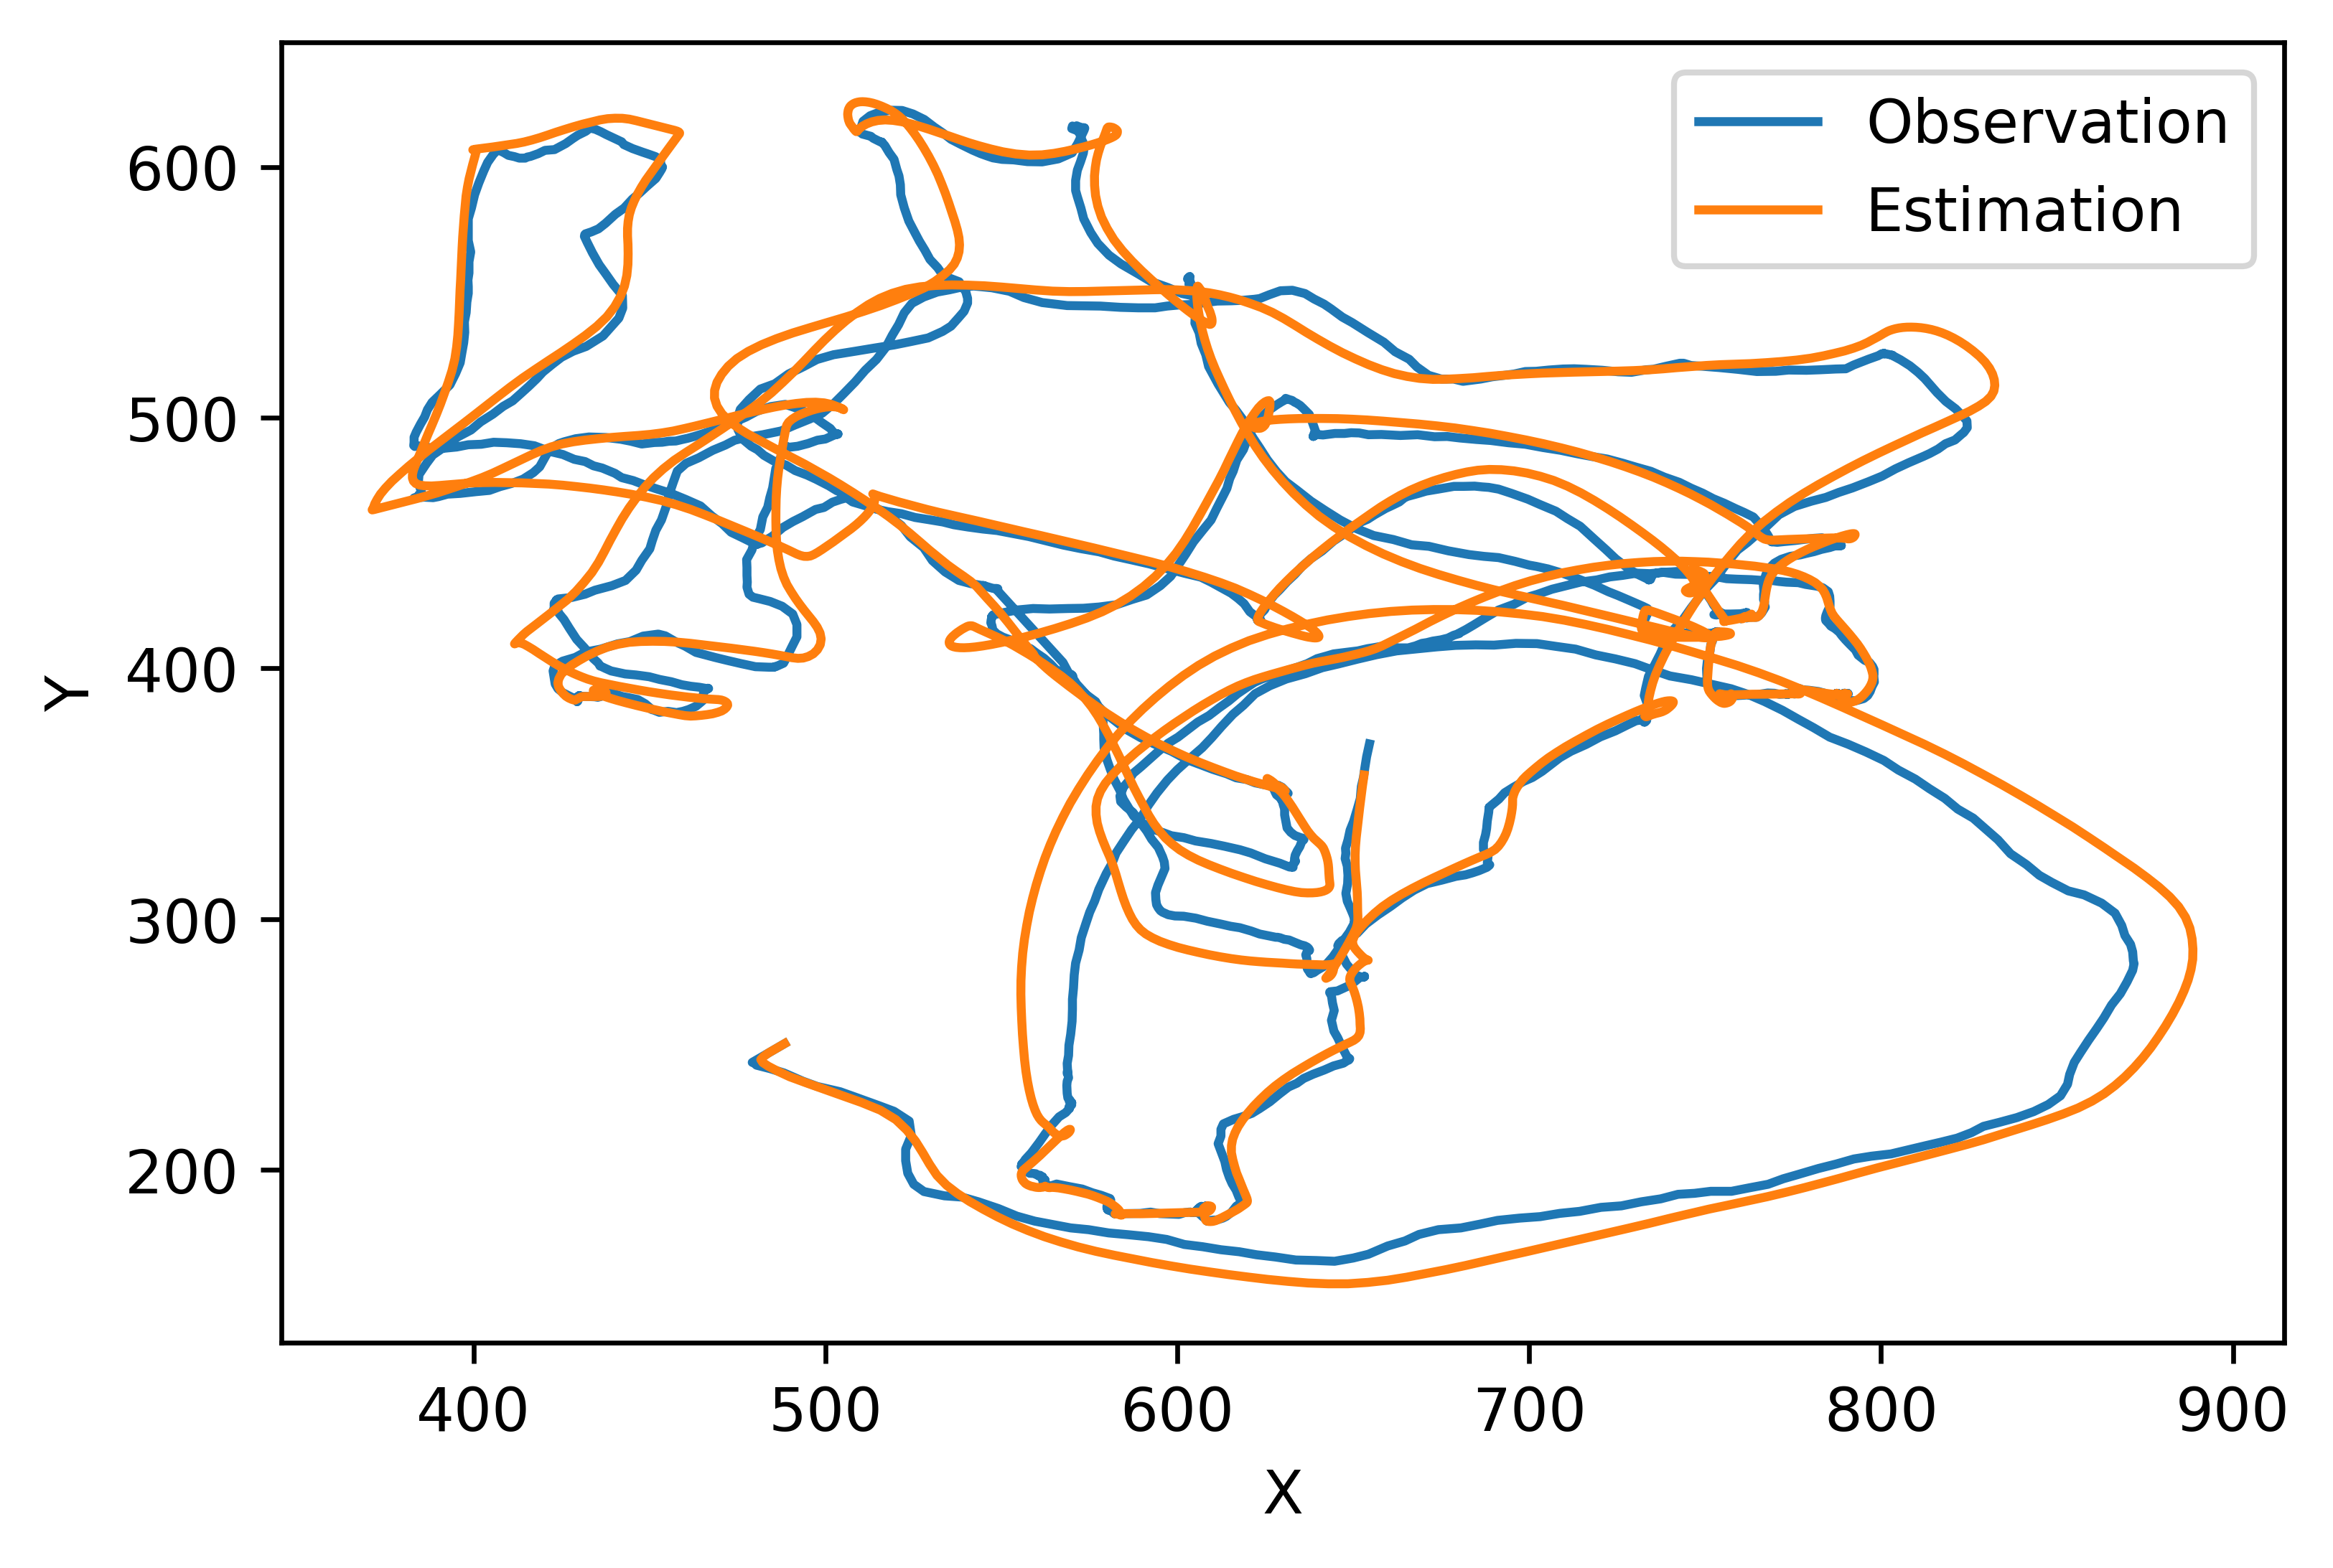

In [7]:
# Draw the estimated trajectory with optimal filter parameters.
fig = plt.figure(dpi=600)
plt.plot(df['x_px'], df['y_px'], linestyle='-', label='Observation')
plt.plot(estimate_traj_mu.reshape(-1, 4)[:, 0], estimate_traj_mu.reshape(-1, 4)[:, 2], 
         linestyle='-', label='Estimation')
plt.legend()
plt.xlabel('X');
plt.ylabel('Y');